In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
X_train=pd.read_csv('X_train.csv')

In [7]:
X_train.head()

,time,seconds_elapsed_orientation,qz_orientation,qy_orientation,qx_orientation,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,seconds_elapsed_location,...,horizontalAccuracy_location_network,speed_location_network,bearing_location_network,altitude_location_network,longitude_location_network,latitude_location_network,seconds_elapsed_gravity,z_gravity,y_gravity,x_gravity
0,1694857537318869200,1228.074843,-0.626221,0.386100,-0.674631,0.060399,-1.826153,0.600508,-2.571477,1228.069,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,1228.074843,-2.041392,-5.524593,7.841044
1,1694857182616775700,873.374776,-0.013953,-0.618994,-0.425122,0.660245,-1.723670,0.575310,0.706575,873.070,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,873.374776,-1.252387,-5.323759,8.139995
2,1694850675496257000,488.368257,0.529413,-0.843842,0.045404,0.074776,-2.755124,1.090140,-0.343697,488.191,...,800.000000,0.0,0.0,0.0,3.123176,50.672179,488.368257,-4.202703,-8.689218,1.733541
3,1694856574973923600,265.731924,-0.103478,-0.568592,-0.501415,0.643878,-1.747675,0.556275,0.976151,265.072,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,265.731924,-1.467729,-5.174577,8.199995
4,1697611168928672300,191.401327,-0.176786,0.565639,-0.799976,0.094012,-2.952015,0.358007,-1.945084,191.092,...,34.563000,0.0,0.0,90.5,3.132056,50.687971,191.401327,-9.001679,-3.482618,1.735401


In [4]:
#  We identified outliers in the following columns during Exploratory Data Analysis (EDA):
#  ['speedAccuracy_location', 'vertical_accuracy_location_network', 'horizontalAccuracy_location',
#  'verticalAccuracy_location', 'speed_location', 'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
#  'horizontalAccuracy_location_gps', 'atitude_location_gps', 'verticalAccuracy_location_network',
#  'horizontalAccuracy_location_network', 'atitude_location_network'].
#  We'll replace these outliers with the median value for each respective column.

class OutlierHandlerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data_to_transform = X[self.columns]
        transformed_data = self.imputer.fit_transform(data_to_transform)
        X[self.columns] = transformed_data
        return X

In [5]:
# Since it was observed through exploratory data analysis (EDA) that columns related to elapsed time are similar, 
# we want to consolidate them by calculating their mean value. This transformer computes the average of the elapsed time
# values and removes the individual columns to avoid redundant information.

class AverageSecondsElapsedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='seconds_elapsed_'):
        self.keyword = keyword
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['seconds_elapsed_time'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [6]:
len(X_train['seconds_elapsed_pedometer'].loc[X_train['seconds_elapsed_pedometer']<0])/len(X_train)

0.19810154013398834

In [7]:
# We have decided to drop the seconds_elapsed_time_pedometer column from our dataset. This decision is based on 
# the fact that 20% of its values are negative, and we are uncertain about the cause (possibly a device issue or a time shift). 
# Since we have other columns capturing elapsed time, we can safely remove this problematic column.

# Additionally, we will use a transformer to drop columns that contain only a single unique value, as they do not 
# provide any useful information for our model. We will also drop the original time column after extracting relevant time features from it.

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            X = X.drop(columns=self.columns, errors='ignore')
        return X

In [ ]:
# Since we already have roll, pitch and yaw orientation values
# we do not need to convert quaterions (qx, qy, qz, qw) to Euler angles.

In [8]:
# Adding time features to capture the hour and minute of the day, which may be relevant for detecting patterns
# in the data. Since we are extracting time features, we will drop the original time column, which serves a role
# in our dataset similar to primary key.

class TimeFeatureExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['time'] = pd.to_datetime(X['time'], unit='ns')
        X['hour'] = X['time'].dt.hour
        X['minute'] = X['time'].dt.minute
        return X

In [9]:
# Based on our exploratory data analysis (EDA), we have identified that there are columns containing speed values. 
# We can reasonably assume that these speed-related columns will be among the most important features for our clasterization activity model.

X_train['speed_location_gps'].corr(X_train['speed_location'])

0.9808731877586914

In [10]:
# xGPS data tends to offer higher accuracy as it relies on satellite signals. However, its precision may fluctuate 
# due to atmospheric conditions or terrain. On the other hand, location data can be more reliable in areas where 
# GPS signals are inaccessible, such as indoors or in regions with poor signal coverage.

X_train[['speed_location_gps', 'speed_location']].loc[X_train['speed_location_gps']!=X_train['speed_location']]

,speed_location_gps,speed_location
0,6.602857,6.583204
1,5.193032,5.214794
2,4.892950,4.993772
3,5.824082,5.807374
4,6.181814,6.133829
...,...,...
1543562,0.000000,0.835902
1543563,0.800908,0.854354
1543564,3.083701,2.689046
1543565,0.949663,1.058741


In [16]:
print(X_train['speed_location_gps'].describe(), X_train['speed_location'].describe())

count    1.543567e+06
mean     2.987227e+00
std      2.745493e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.486108e+00
75%      5.497233e+00
max      1.074791e+01
Name: speed_location_gps, dtype: float64 count    1.543567e+06
mean     3.040514e+00
std      2.700369e+00
min      0.000000e+00
25%      2.457211e-01
50%      2.538605e+00
75%      5.501579e+00
max      1.514773e+01
Name: speed_location, dtype: float64


In [11]:
len(X_train['speed_location_gps']==0), len(X_train['speed_location']==0)

(1543567, 1543567)

In [12]:
# After careful analysis of these two variables, considering their relatively minor discrepancies,
#  we've opted to compute a simple mean of these columns and consolidate them into a single column named 'speed'.

class AverageSpeedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='speed_location'):
        self.keyword = keyword
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['speed'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [13]:
# In our data frame we have 3 different devices representing the geographical location, these are: location, location_gps and
# location_network. To avoid data redundancy and reduce the dimensionality of the data, we average the position data. 
# However, as EDA showed, the data collected from location_network differs significantly from the data collected by location
# and location_gps. This is most likely due to the Internet being turned off during activity, loss of Internet connection or
# interruptions. So we made the decision to average the data from location and location_gps and discard the data from 
# location_network.

class AverageLocationTransformer(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['longitude'] = X[['longitude_location_gps', 'longitude_location']].mean(axis=1)
        X['latitude'] = X[['latitude_location_gps', 'latitude_location']].mean(axis=1)
        X['altitude'] = X[['altitude_location_gps', 'altitude_location']].mean(axis=1)
        X = X.drop(['longitude_location_gps', 'longitude_location', 'longitude_location_network',
                   'latitude_location_gps', 'latitude_location', 'latitude_location_network',
                   'altitude_location_gps', 'altitude_location', 'altitude_location_network'], axis=1)

        return X

In [14]:
# In the columns total_acceleration, magnetometer, gyroscope, gravity, accelerometer there are 3 dimensions x y z.
# In order to change the dimensionality, we will convert the vector x y z to the Euclidean norm of this vector.

class AccelerationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['acceleration_magnitude'] = np.sqrt(X['x_total_acceleration']**2 + X['y_total_acceleration']**2 + X['z_total_acceleration']**2)
        X = X.drop(['x_total_acceleration', 'y_total_acceleration', 'z_total_acceleration'], axis=1)
        return X

In [15]:
class MagnetometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['magnetometer_magnitude'] = np.sqrt(X['x_magnetometer']**2 + X['y_magnetometer']**2 + X['z_magnetometer']**2)
        X = X.drop(['x_magnetometer', 'y_magnetometer', 'z_magnetometer'], axis=1)
        return X

In [28]:
class GyroscopeIntegrationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['angular_velocity'] = np.sqrt(X['x_gyroscope']**2 + X['y_gyroscope']**2 + X['z_gyroscope']**2)
        X = X.drop(['x_gyroscope', 'y_gyroscope', 'z_gyroscope'], axis=1)
        return X

In [34]:
class GravitationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['gravitation_magnitude'] = np.sqrt(X['x_gravity']**2 + X['y_gravity']**2 + X['z_gravity']**2)
        X = X.drop(['x_gravity', 'y_gravity', 'z_gravity'], axis=1)
        return X

In [38]:
class AccelerometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['accelerometer_magnitude'] = np.sqrt(X['x_accelerometer']**2 + X['y_accelerometer']**2 + X['z_accelerometer']**2)
        X = X.drop(['x_accelerometer', 'y_accelerometer', 'z_accelerometer'], axis=1)
        return X

In [16]:
# Finally, we will standardize the features, including geographical coordinates, as our area is small, 
# making Euclidean distance appropriate for our purposes.

# Additionally, we'll utilize a custom standard scaler to preserve the structure of the DataFrame.

class PandasStandardScaler(StandardScaler):
    def fit_transform(self, X, y=None):
        scaled_data = super().fit_transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

In [53]:
pipeline = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation'])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('average_location_transformer', AverageLocationTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('magnetometer_magnitude_transformer', MagnetometerMagnitudeTransformer()),
    ('gyroscope_integration_transformer', GyroscopeIntegrationTransformer()),
    ('gravitation_magnitude_transformer', GravitationMagnitudeTransformer()),
    ('accelerometer_magnitude_transformer', AccelerometerMagnitudeTransformer()),
    ('time_feature_extractor', TimeFeatureExtraction()),
    ('time_dropper', ColumnDropper(columns=['time'])),
    ('scaler', PandasStandardScaler())
])

In [54]:
X_train_transformed = pipeline.fit_transform(X_train)

In [55]:
X_train_transformed.head()

,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,horizontalAccuracy_location,bearing_location,bearingAccuracy_location_gps,speedAccuracy_location_gps,...,longitude,latitude,altitude,acceleration_magnitude,magnetometer_magnitude,angular_velocity,gravitation_magnitude,accelerometer_magnitude,hour,minute
0,-0.061553,-0.053867,-1.187582,-0.244330,-0.007997,0.062353,-0.482387,0.603721,-0.873943,-0.705776,...,0.835813,-0.114667,1.217900,-0.917197,-0.521485,0.225325,-0.780802,0.012079,-0.193806,0.662358
1,0.002335,-0.102818,0.677356,-0.173736,0.072607,0.027813,0.094596,-0.881413,-0.828722,-0.603985,...,0.218021,-2.496030,-0.568761,0.219089,0.547713,-0.862257,-0.501944,-0.451705,-0.193806,0.225030
2,-0.640670,0.897339,0.079839,0.194678,1.523495,0.096893,-0.374800,1.494130,-0.592724,1.228250,...,-0.251729,-0.672915,-1.123566,-0.711613,0.905798,-0.056848,-1.112998,-0.178222,-0.617873,1.099686
3,-0.012630,-0.139797,0.830722,-0.224476,-0.007997,0.161038,-0.482387,-0.612742,-0.861225,-0.705776,...,-1.016309,-0.700175,-0.691006,-0.496328,-0.037168,-0.555316,-0.324486,-0.427612,-0.193806,-0.503850
4,-0.763412,-0.524971,-0.831216,-0.394343,-0.975255,-0.525402,-0.384913,0.701639,-0.810351,0.210341,...,0.621131,0.936027,1.542320,-0.621668,-0.987766,1.156519,2.586604,-0.268821,-0.829907,0.225030


In [56]:
X_train_transformed.columns

Index(['roll_orientation', 'pitch_orientation', 'yaw_orientation',
       'bearingAccuracy_location', 'speedAccuracy_location',
       'verticalAccuracy_location', 'horizontalAccuracy_location',
       'bearing_location', 'bearingAccuracy_location_gps',
       'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'steps_pedometer', 'verticalAccuracy_location_network',
       'horizontalAccuracy_location_network', 'seconds_elapsed_time', 'speed',
       'longitude', 'latitude', 'altitude', 'acceleration_magnitude',
       'magnetometer_magnitude', 'angular_velocity', 'gravitation_magnitude',
       'accelerometer_magnitude', 'hour', 'minute'],
      dtype='object')

In [57]:
len(X_train_transformed.columns)

28

## PCA

In [58]:
# PCA for 1 component

pca = PCA(n_components=1)
pca.fit(X_train_transformed)

PCA(n_components=1)

In [59]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca.explained_variance_[0]:.4f}')
print(pca.explained_variance_ratio_)

Total variance: 1.0000
Explained variance: 5.5839
[0.19942351]


In [60]:
# PCA for 2 components

pca2 = PCA(n_components=2)
principal_components = pca2.fit_transform(X_train_transformed)

In [61]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca2.explained_variance_[0]:.4f}')
print(pca2.explained_variance_ratio_)

Total variance: 1.0000
Explained variance: 5.5839
[0.19942351 0.160239  ]


In [62]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

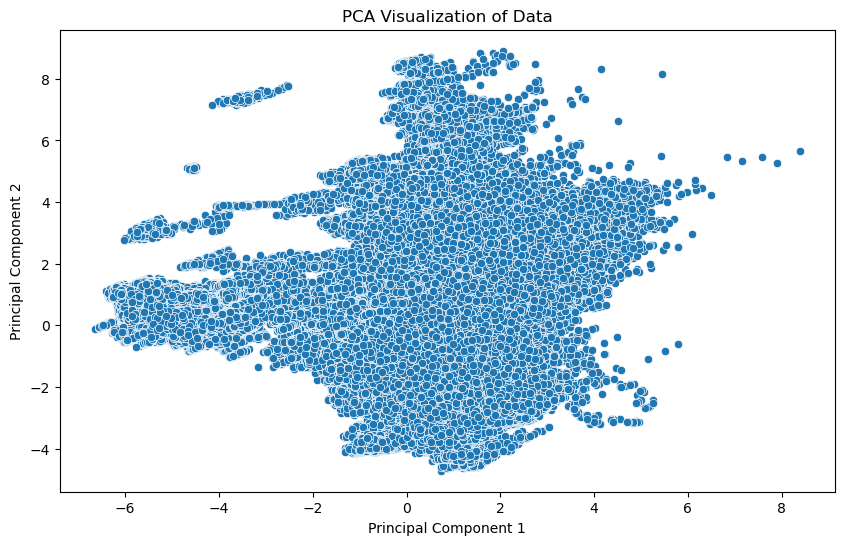

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [64]:
# PCA for 3 components

pca3 = PCA(n_components=3)
principal_components = pca3.fit_transform(X_train_transformed)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

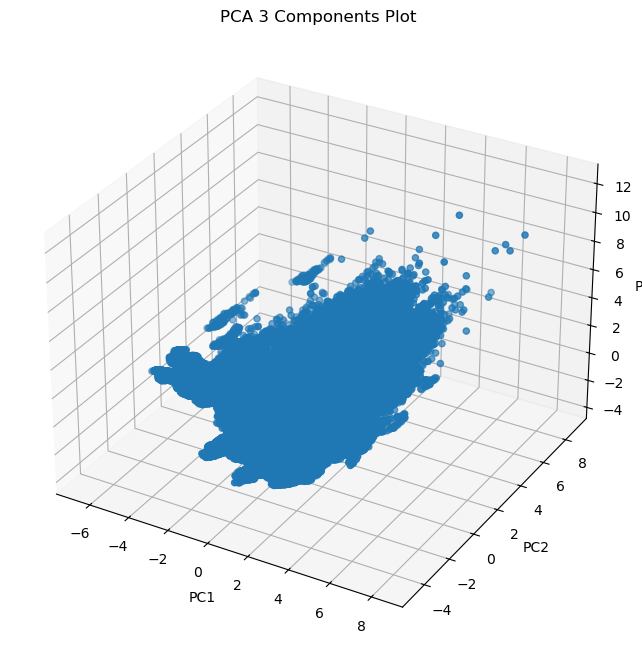

In [65]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3 Components Plot')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

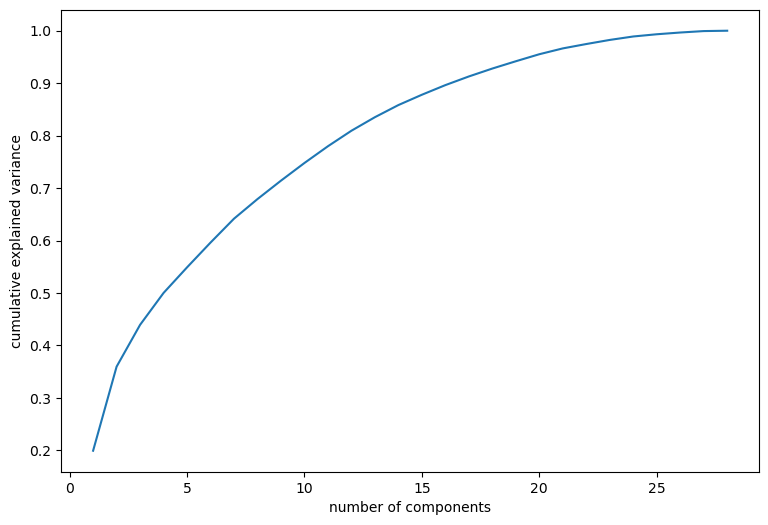

In [66]:
# We can observe that for approximately 20 components, we achieve a cumulative explained variance ratio of about 90%. 
# However, having 20 components still represents a considerable number of variables, so we'll attempt to reduce this number.

pca = PCA().fit(X_train_transformed)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## TSNE

In [67]:
def scatter_tsne(x):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    unique_colors = np.linspace(0, 1, len(x))
    palette = plt.cm.rainbow(unique_colors)

    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette)

    plt.xlim(np.min(x[:,0])-0.1, np.max(x[:,0])+0.1)
    plt.ylim(np.min(x[:,1])-0.1, np.max(x[:,1])+0.1)
    
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

In [113]:
%%time

X_train_transformed_sample = resample(X_train_transformed, n_samples=100000, random_state=42)

tSNE = TSNE(random_state=42, verbose=1)
digits_proj_sample = tSNE.fit_transform(X_train_transformed_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.014s...
[t-SNE] Computed neighbors for 100000 samples in 19.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x1ceee6f7880>)

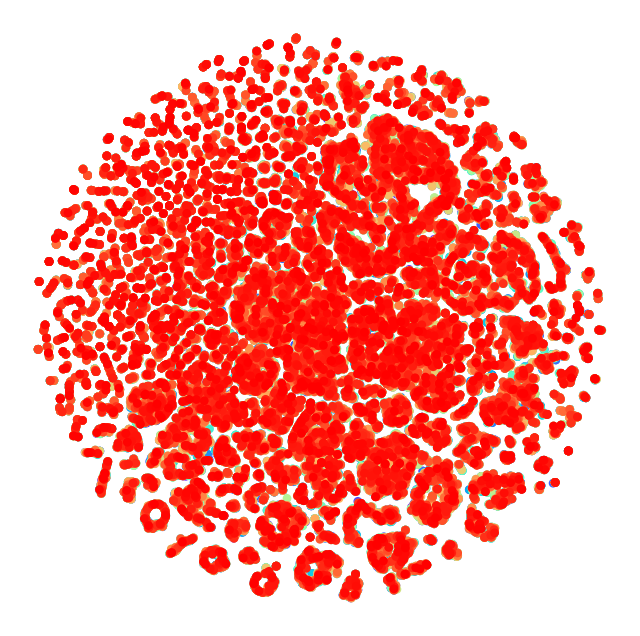

In [114]:
scatter_tsne(digits_proj_sample)

## PCA for each device

In [37]:
# We categorize the data based on the originating device.

devices = {
    'location_group': [ 'seconds_elapsed_location', 'bearingAccuracy_location',
                        'speedAccuracy_location', 'verticalAccuracy_location',
                        'horizontalAccuracy_location', 'speed_location', 'bearing_location',
                        'altitude_location', 'longitude_location', 'latitude_location'],
    'orientation_group': ['seconds_elapsed_orientation', 'qz_orientation',
                        'qy_orientation', 'qx_orientation', 'qw_orientation',
                        'roll_orientation', 'pitch_orientation', 'yaw_orientation',],
    'total_acceleration_group': ['seconds_elapsed_total_acceleration', 'z_total_acceleration',
                        'y_total_acceleration', 'x_total_acceleration'],
    'magentometer_group':['seconds_elapsed_magnetometer', 'z_magnetometer', 'y_magnetometer',
                         'x_magnetometer'],
    'accelerometer_group':['seconds_elapsed_accelerometer', 'z_accelerometer',
                        'y_accelerometer', 'x_accelerometer'],
    'location_gps_group':['seconds_elapsed_location_gps',
                    'bearingAccuracy_location_gps', 'speedAccuracy_location_gps',
                    'verticalAccuracy_location_gps', 'horizontalAccuracy_location_gps',
                    'speed_location_gps', 'bearing_location_gps', 'altitude_location_gps',
                    'longitude_location_gps', 'latitude_location_gps'],
    'gyroscope_group':['seconds_elapsed_gyroscope', 'z_gyroscope', 'y_gyroscope',
                    'x_gyroscope'],
    'pedometer_group':['seconds_elapsed_pedometer', 'steps_pedometer'],
    'location_network_group':['seconds_elapsed_location_network', 'bearingAccuracy_location_network',
                    'speedAccuracy_location_network', 'verticalAccuracy_location_network',
                    'horizontalAccuracy_location_network', 'speed_location_network',
                    'bearing_location_network', 'altitude_location_network',
                    'longitude_location_network', 'latitude_location_network'],
    'gravity_group':['seconds_elapsed_gravity', 'z_gravity', 'y_gravity', 'x_gravity']
}

In [126]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [ ]:
# Decision to use PCA for each device:
# The first step involves applying PCA to the data from each device, retaining only their first component.
# Utilizing PCA is advantageous as it enables dimensionality reduction and eliminates correlations between variables,
# which is particularly crucial for data originating from different sensors that may have varying scales and units.
# Retaining only the first component preserves the most significant features of the data while reducing its dimensionality.
# Subsequently, based on the PCA results for each device, we conduct the final transformation
# into a two-dimensional space using PCA, enabling data visualization and analysis of patterns across devices.

In [39]:
group_pca_results = pd.DataFrame()
for group_name, columns in devices.items():
    pipeline = Pipeline([
        ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
        ('selector', ColumnSelector(columns=columns)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])
    pca_result = pipeline.fit_transform(X_train)
    group_pca_results[group_name] = pca_result.flatten()
    #temp_df = pd.DataFrame(pca_result, columns=[f"{group_name}_pca1", f"{group_name}_pca2"])
    #group_pca_results = pd.concat([group_pca_results, temp_df], axis=1)



In [40]:
group_pca_results

,location_group,orientation_group,total_acceleration_group,magentometer_group,accelerometer_group,location_gps_group,gyroscope_group,pedometer_group,location_network_group,gravity_group
0,1.286949,0.995369,0.896543,0.202076,-0.786841,-2.267884,0.931829,3.414791,0.166272,0.499945
1,0.970178,1.443131,0.248386,-0.764515,0.283522,-1.444179,-0.278888,2.053330,0.166272,0.256931
2,-1.544776,-0.840796,0.670025,-1.423068,-0.618162,-0.730751,-0.084284,0.618295,3.495257,1.033391
3,-0.940009,1.100068,-0.277826,0.003122,-0.493028,-0.732108,-0.561056,-0.312044,0.166272,-0.288989
4,0.665972,-0.283583,-0.587647,1.071452,-0.629058,-1.508517,1.600475,-0.579177,-1.276561,-0.827755
...,...,...,...,...,...,...,...,...,...,...
1543562,-0.033870,0.588443,2.424455,-2.631281,-0.021746,1.054573,0.012354,2.179862,-1.637775,2.681413
1543563,2.072464,2.737400,0.998270,-0.550398,0.194089,-0.480924,2.485830,0.383802,-1.260196,1.931418
1543564,1.913177,0.699848,0.480337,-0.793867,0.241719,-1.214129,0.307278,1.828091,0.166272,-0.192415
1543565,2.024923,2.310188,3.054222,-0.623078,-0.175260,-0.676144,-2.154432,0.353504,-1.254056,1.442190


In [41]:
pca_per_device = PCA(n_components=2)

final_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('final_pca', pca_per_device)
])

In [42]:
final_pca_transformed = final_pca_pipeline.fit_transform(group_pca_results)
final_pca_df = pd.DataFrame(final_pca_transformed, columns=['PC1', 'PC2'])

In [43]:
print(f'Total variance: {np.sqrt(np.std(group_pca_results)).iloc[0]:.4f}')
print(f'Explained variance: {pca_per_device.explained_variance_[0]:.4f}')
print(pca_per_device.explained_variance_ratio_)

Total variance: 1.2479
Explained variance: 4.8454
[0.48454463 0.12161065]


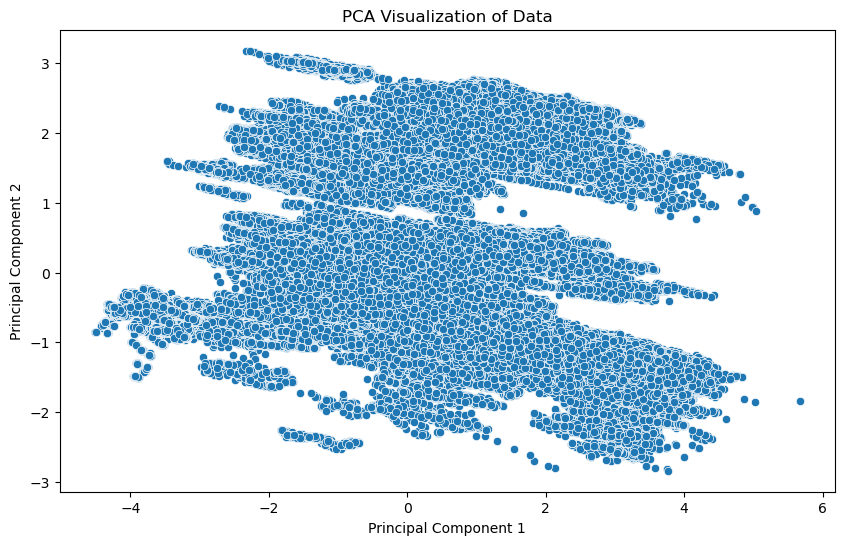

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=final_pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [45]:
pca_per_device_test = PCA().fit(group_pca_results)

Text(0, 0.5, 'cumulative explained variance')

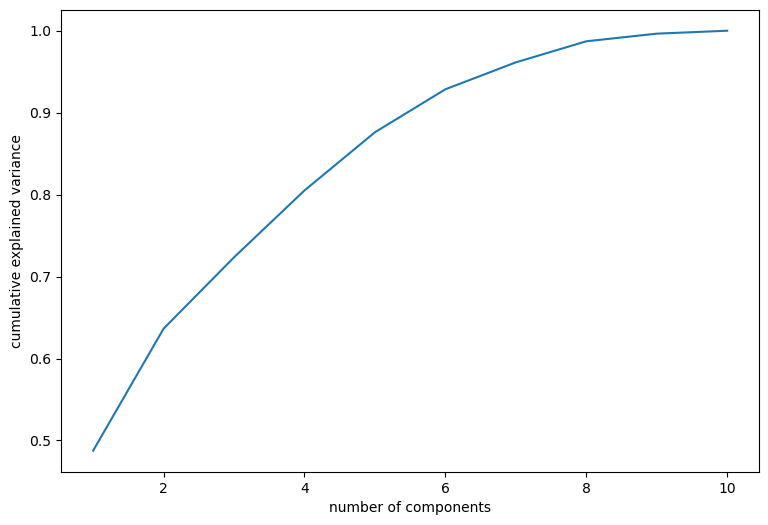

In [46]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca_per_device_test.explained_variance_ratio_)+1), np.cumsum(pca_per_device_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Testing clasterization models

In [47]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(final_pca_df)

labels = kmeans.labels_
print(labels)

[1 1 0 ... 1 1 0]


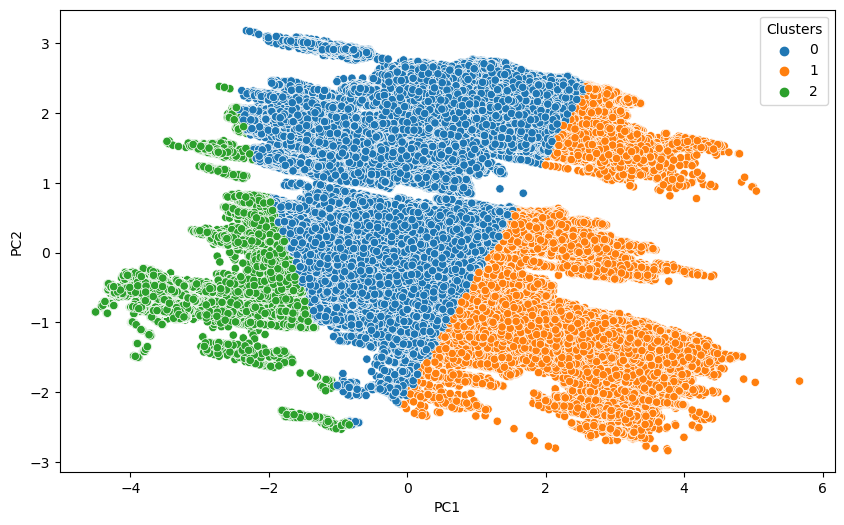

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_pca_df['PC1'], y=final_pca_df['PC2'], hue=labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [49]:
# Due to performance issues, we're using only a sample of the data, as running DBSCAN on 
# 1.5 million records caused the kernel to crash.

sampled_data = final_pca_df.sample(n=20000, random_state=42)
dbscan = DBSCAN(eps=0.3, min_samples=4)
dbscan.fit(sampled_data)
db_labels = dbscan.labels_
print(db_labels)

[ 0 -1  1 ...  1  1  1]


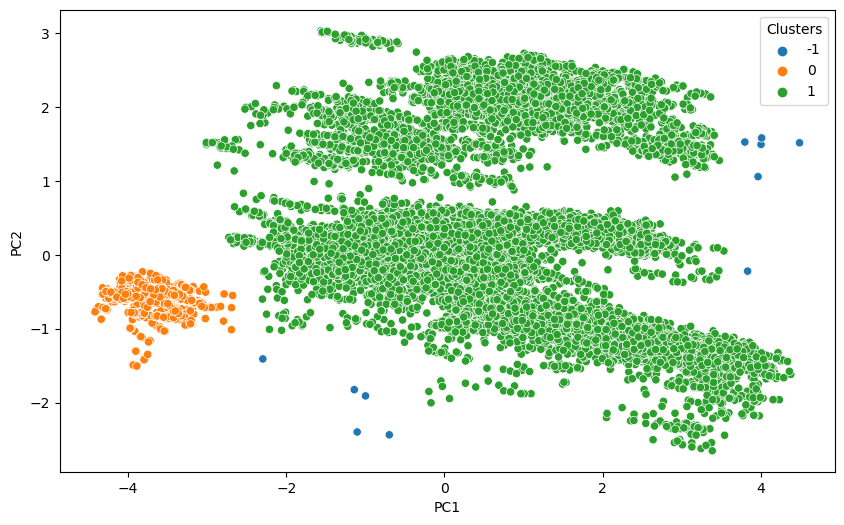

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sampled_data['PC1'], y=sampled_data['PC2'], hue=db_labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Devices without location_network_group and location_gps_group

In [193]:
devices_2 = {
    'location_group': [ 'seconds_elapsed_location', 'bearingAccuracy_location',
                        'speedAccuracy_location', 'verticalAccuracy_location',
                        'horizontalAccuracy_location', 'speed_location', 'bearing_location',
                        'altitude_location', 'longitude_location', 'latitude_location'],
    'orientation_group': ['seconds_elapsed_orientation', 'qz_orientation',
                        'qy_orientation', 'qx_orientation', 'qw_orientation',
                        'roll_orientation', 'pitch_orientation', 'yaw_orientation',],
    'total_acceleration_group': ['seconds_elapsed_total_acceleration', 'z_total_acceleration',
                        'y_total_acceleration', 'x_total_acceleration'],
    'magentometer_group':['seconds_elapsed_magnetometer', 'z_magnetometer', 'y_magnetometer',
                         'x_magnetometer'],
    'accelerometer_group':['seconds_elapsed_accelerometer', 'z_accelerometer',
                        'y_accelerometer', 'x_accelerometer'],
    'gyroscope_group':['seconds_elapsed_gyroscope', 'z_gyroscope', 'y_gyroscope',
                    'x_gyroscope'],
    'pedometer_group':['seconds_elapsed_pedometer', 'steps_pedometer'],
    'gravity_group':['seconds_elapsed_gravity', 'z_gravity', 'y_gravity', 'x_gravity']
}

In [194]:
class ColumnSelector_2(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [195]:
group_pca_results_2 = pd.DataFrame()
for group_name, columns in devices_2.items():
    pipeline = Pipeline([
        ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
        ('selector', ColumnSelector_2(columns=columns)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])
    
    pca_result_2 = pipeline.fit_transform(X_train)
    group_pca_results_2[group_name] = pca_result_2.flatten()
    #temp_df = pd.DataFrame(pca_result, columns=[f"{group_name}_pca1", f"{group_name}_pca2"])
    #group_pca_results = pd.concat([group_pca_results, temp_df], axis=1)



In [196]:
pca_per_device_2 = PCA(n_components=2)

final_pca_pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('final_pca', pca_per_device_2)
])

In [197]:
final_pca_transformed_2 = final_pca_pipeline_2.fit_transform(group_pca_results_2)
final_pca_df_2 = pd.DataFrame(final_pca_transformed_2, columns=['PC1', 'PC2'])

In [198]:
print(f'Total variance: {np.sqrt(np.std(group_pca_results_2)).iloc[0]:.4f}')
print(f'Explained variance: {pca_per_device_2.explained_variance_[0]:.4f}')
print(pca_per_device_2.explained_variance_ratio_)

Total variance: 1.2479
Explained variance: 4.5593
[0.56991488 0.13577908]


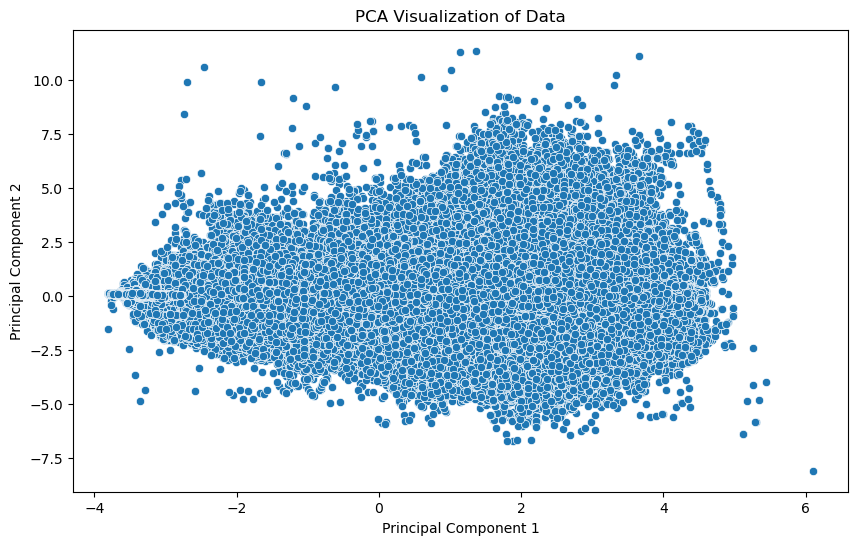

In [199]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=final_pca_df_2)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [200]:
pca_per_device_test_2 = PCA().fit(group_pca_results_2)

Text(0, 0.5, 'cumulative explained variance')

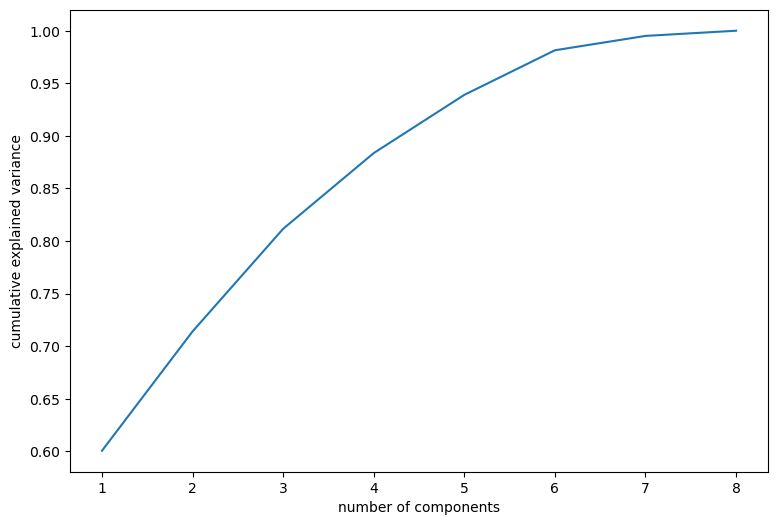

In [201]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca_per_device_test_2.explained_variance_ratio_)+1), np.cumsum(pca_per_device_test_2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [202]:
group_pca_results_2

,location_group,orientation_group,total_acceleration_group,magentometer_group,accelerometer_group,gyroscope_group,pedometer_group,gravity_group
0,1.286949,0.995369,0.896543,0.202076,-0.786841,0.931829,3.414791,0.499945
1,0.970178,1.443131,0.248386,-0.764515,0.283522,-0.278888,2.053330,0.256931
2,-1.544776,-0.840796,0.670025,-1.423068,-0.618162,-0.084284,0.618295,1.033391
3,-0.940009,1.100068,-0.277826,0.003122,-0.493028,-0.561056,-0.312044,-0.288989
4,0.665972,-0.283583,-0.587647,1.071452,-0.629058,1.600475,-0.579177,-0.827755
...,...,...,...,...,...,...,...,...
1543562,-0.033870,0.588443,2.424455,-2.631281,-0.021746,0.012354,2.179862,2.681413
1543563,2.072464,2.737400,0.998270,-0.550398,0.194089,2.485830,0.383802,1.931418
1543564,1.913177,0.699848,0.480337,-0.793867,0.241719,0.307278,1.828091,-0.192415
1543565,2.024923,2.310188,3.054222,-0.623078,-0.175260,-2.154432,0.353504,1.442190


In [203]:
n_clusters = 3
kmeans_2 = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_2.fit(final_pca_df_2)

labels_2 = kmeans_2.labels_
print(labels_2)

[2 2 0 ... 2 2 0]


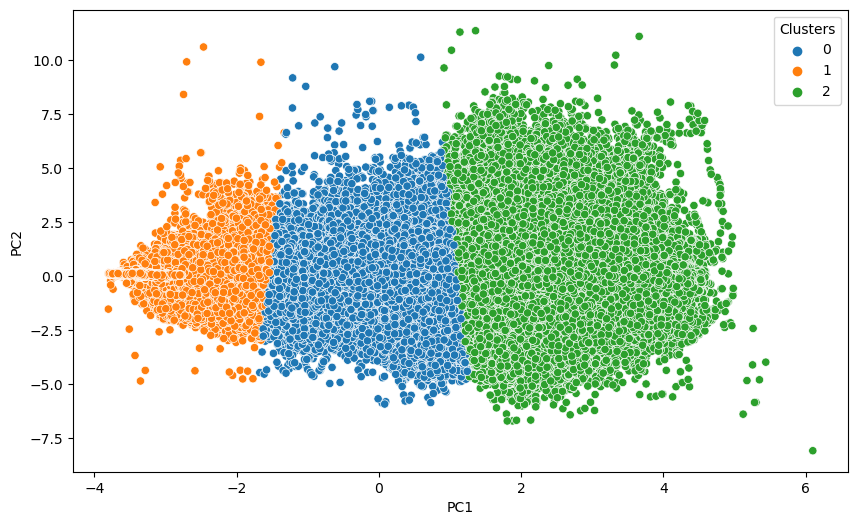

In [204]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_pca_df_2['PC1'], y=final_pca_df_2['PC2'], hue=labels_2, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()